---

<h1 align="center">Transfer Learning</h1>


---



This notebook demonstrates how to load a pretrained model **(VGG16)** from PyTorch, and modify this to train on the **CIFAR10** dataset.



### Steps to be followed:
1. Load the pretrained model (VGG16) in this case.
2. Check the layer names, and the identify the layers that you wish to modify.
3. Create a custom class to include all the necessary modifications, and assign it to the layer to be modified. For eg, to change the (avgpool) layer in VGG16 to a layer defined by the *New_Layer()* custom class, do the following:

  ```
      class New_Layer():
        def __init__(self):
          ...

        def forward(self,...):
          ...

      model.avgpool = New_Layer(nn.Module) 
  ```
4. For only finetuning, set requires_grad = False. This preserves the weights of the pre-trained model.
```            
          for param in model.parameters():
              param.requires_grad = False
```            
5. Train the network on a new Dataset, in this case **CIFAR10**.





In [28]:
import torch
import torchvision
import torch.nn as nn                     # For all Neural network modules, Linear, Conv2d, BatchNorm, Loss functions,etc.
import torch.optim as optim               # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F           # For all functions that do not have any parameters
from torch.utils.data import DataLoader   # For easier dataset management/mini batching
import torchvision.datasets as datasets   # Has standard datasets that we can import
import torchvision.transforms as transforms  # For Transformations to be performed on our dataset
from torch.utils.data import random_split
from torchvision.utils import make_grid   # Generate and display a Grid of Images
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
# Hyperparameters
EPOCHS = 100
NUM_CLASSES = 10
lr = 1e-4
batch_size = 512

## Experiments with the pre-trained model:

The following cells demonstrate how to add/modify layers to the original pre-trained model.

In [31]:
# Load the pretrained VGG16 model
model = torchvision.models.vgg16(pretrained=True)

In [32]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
## We want to remove the Average Pooling (avgpool) layer [rather convert it to an Identity layer]

## Define a Custom Identity layer
class Identity(nn.Module):
  def __init__(self):
    super(Identity,self).__init__()

  def forward(self,x):
    return x

In [34]:
## Replace the (avgpool) layer with the custom Identity layer
model.avgpool = Identity()
## Replace the final (classifier layer) to a FC layer
'''
To change a specific layer in the Sequential layer (classifer), we can do the following:
model.classifier[0] = nn.Linear(512,NUM_CLASSES)
'''
model.classifier = nn.Linear(512,NUM_CLASSES)

In [35]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loading and Visualizing the Dataset

In [36]:

dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='dataset/', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [37]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [38]:
class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

In [39]:
print(f"Total data items: {len(dataset)}")
torch.manual_seed(78)
val_size = 2000
train_size = len(dataset) - val_size

Total data items: 50000


In [40]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(48000, 2000)

In [41]:
'''
shuffle=True : for the training dataloader, so that the batches generated in each epoch are different. This randomization helps in generalization.
pin_memory=True :   Enables fast data transfer to CUDA-enabled GPUs.
num_workers: Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes.
'''

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Image shape: torch.Size([512, 3, 32, 32])


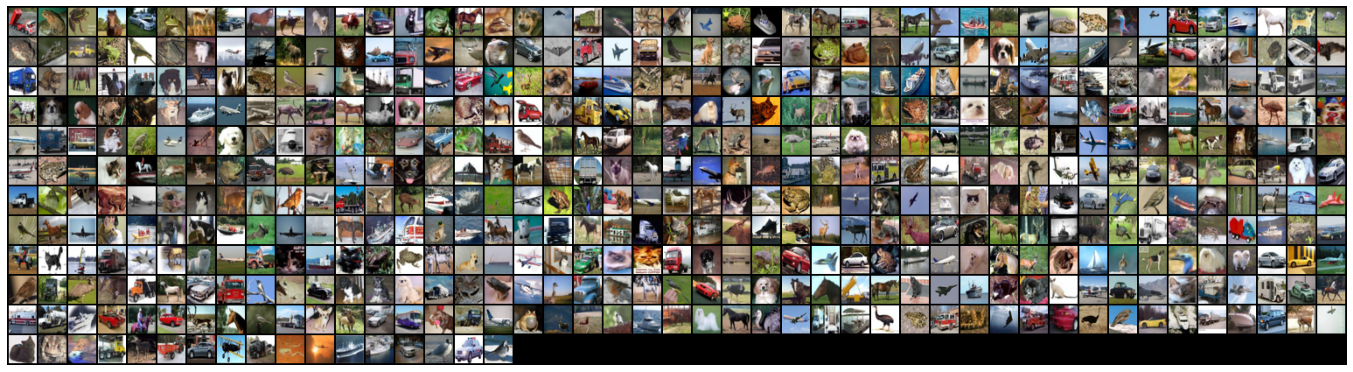

In [51]:
for images, _ in train_loader:
    print('Image shape:', images.shape)
    plt.figure(figsize=(24,15))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=45).permute((1, 2, 0)))
    break

## Defining the Model Class

In [44]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [45]:
## Model Class with the appended final layer suited for the CIFAR dataset
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.vgg16(pretrained=True)
        '''
           For only finetuning, set requires_grad = False.
            `
            for param in model.parameters():
                param.requires_grad = False
            `
            This will preserve the weights of the pre-trained model, allowing training only for the appended layer            
        '''
        self.model.avgpool = Identity()
        self.model.classifier = nn.Sequential(
                                  nn.Linear(512, 100), nn.Dropout(), nn.ReLU(), nn.Linear(100, NUM_CLASSES)
                                )
        
    def forward(self, x):        
        out = self.model(x)
        return out

In [43]:
## Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [46]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. #Epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. #Epochs');

In [48]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
model = to_device(CIFAR10Model(), device)

In [23]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.08351209759712219, 'val_loss': 2.3543143272399902}]

In [24]:
history += fit(EPOCHS,lr, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.7356, val_acc: 0.7691
Epoch [1], val_loss: 0.5896, val_acc: 0.8080
Epoch [2], val_loss: 0.5009, val_acc: 0.8393
Epoch [3], val_loss: 0.4912, val_acc: 0.8561
Epoch [4], val_loss: 0.5203, val_acc: 0.8455
Epoch [5], val_loss: 0.5398, val_acc: 0.8571
Epoch [6], val_loss: 0.5498, val_acc: 0.8642
Epoch [7], val_loss: 0.6174, val_acc: 0.8547
Epoch [8], val_loss: 0.6405, val_acc: 0.8677
Epoch [9], val_loss: 0.6649, val_acc: 0.8682
Epoch [10], val_loss: 0.7283, val_acc: 0.8605
Epoch [11], val_loss: 0.8190, val_acc: 0.8661
Epoch [12], val_loss: 0.7518, val_acc: 0.8679
Epoch [13], val_loss: 0.7060, val_acc: 0.8677
Epoch [14], val_loss: 0.7721, val_acc: 0.8742
Epoch [15], val_loss: 0.8274, val_acc: 0.8733
Epoch [16], val_loss: 0.8699, val_acc: 0.8667
Epoch [17], val_loss: 0.8689, val_acc: 0.8616
Epoch [18], val_loss: 0.8140, val_acc: 0.8659
Epoch [19], val_loss: 0.7481, val_acc: 0.8651
Epoch [20], val_loss: 0.8912, val_acc: 0.8732
Epoch [21], val_loss: 0.7726, val_acc: 0.871

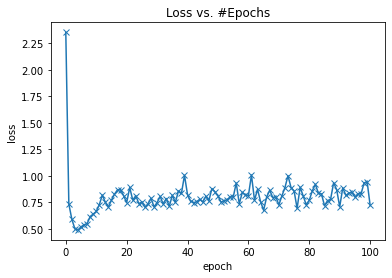

In [25]:
plot_losses(history)

In [51]:
plot_accuracies(history)

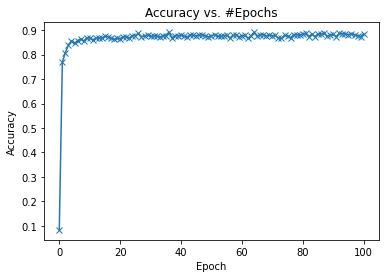

### Results

---



After 100 epochs, the model achieves 88% accuracy on the Test set.

In [27]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.8807697296142578, 'val_loss': 0.7604606747627258}